In [73]:
import networkx as nx
import matplotlib.pyplot as plt
import json
import seaborn as sns
import pandas as pd
import wandb

from opf.dataset import CaseDataModule
from torch_geometric.utils import to_networkx

sns.set_theme(
    context="paper",
    style="ticks",
    font_scale=0.8,
    rc={
        "figure.figsize": (3.5, 2.0),
        "figure.dpi": 300,
        "savefig.dpi": 300,
        "text.usetex": True,
        "lines.linewidth": 0.7,
        "axes.linewidth": 0.7,
        "axes.grid": True,
        "grid.linestyle": "--",
        "grid.linewidth": 0.5,
        "pdf.fonttype": 42,
    },
)

In [74]:
api = wandb.Api()  # type: ignore

runs = {}
for case_name in [
    "case30_ieee",
    "case57_ieee",
    "case118_ieee",
    "case300_ieee",
    "case1354_pegase",
]:
    # query the W&B API for all the runs in october and november 2024 within the damowerko/opf project
    # filter by case_name and sort by val/invariant
    runs[case_name] = api.runs(
        path="damowerko-academic/opf",
        filters={
            "config.case_name": case_name,
            "created_at": {
                "$gte": "2024-10-01T00:00:00Z",
                "$lt": "2024-12-01T00:00:00Z",
            },
        },
        order="+summary_metrics.val/invariant",
        per_page=10,
    )[0]

In [75]:
import re

# collect the latest validation metrics into a pandas dataframe
# and add the case_name as a column
data = []
for case_name, run in runs.items():
    run_data = run.summary_metrics
    run_data["case_name"] = case_name
    run_data["n_nodes"] = int(re.search(r"\d+", case_name).group())
    data.append(run_data)
df = pd.DataFrame.from_records(data).sort_values("n_nodes")

In [76]:
df[["case_name", "val/invariant"]]

,case_name,val/invariant
0,case30_ieee,0.074603
1,case57_ieee,49.782799
2,case118_ieee,5.674683
3,case300_ieee,16.358225
4,case1354_pegase,26.948048


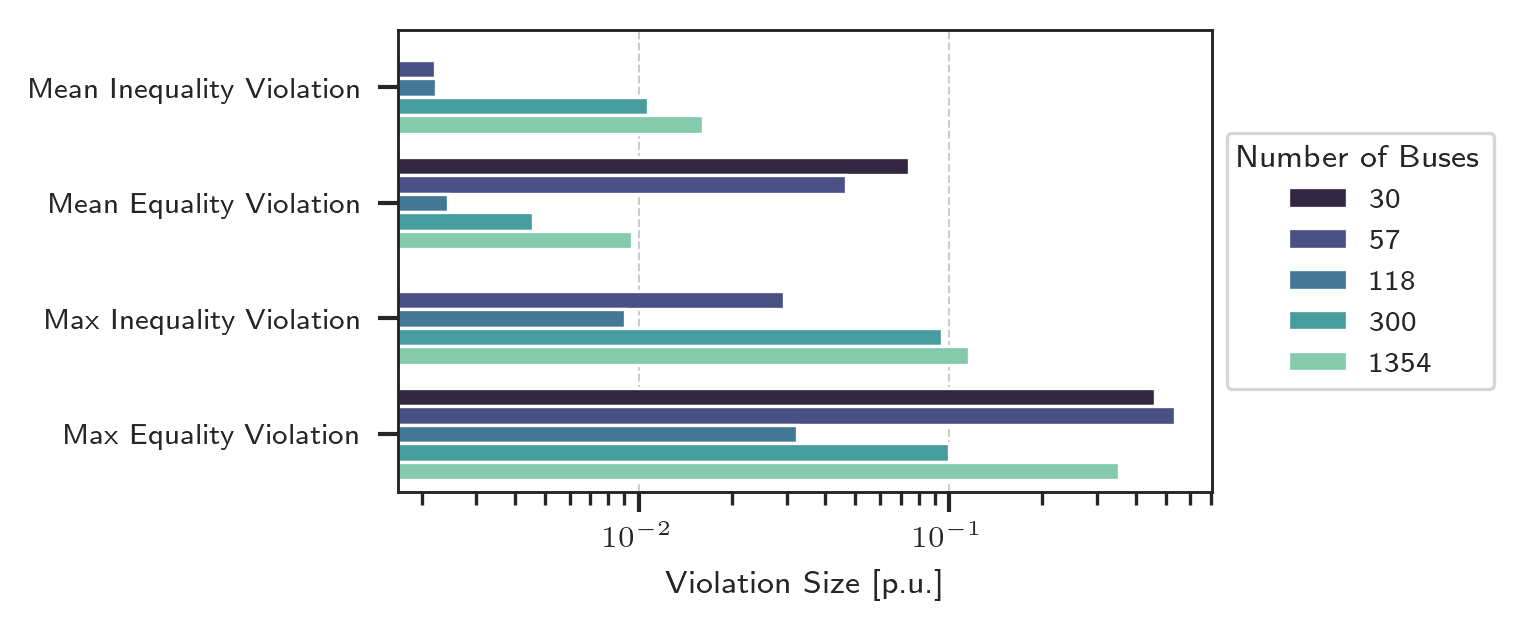

In [77]:
data = (
    df[
        [
            "case_name",
            "n_nodes",
            "val/inequality/error_mean",
            "val/equality/error_mean",
            "val/inequality/error_max",
            "val/equality/error_max",
        ]
    ]
    .rename(
        columns={
            "val/inequality/error_mean": "Mean Inequality Violation",
            "val/inequality/error_max": "Max Inequality  Violation",
            "val/equality/error_mean": "Mean Equality  Violation",
            "val/equality/error_max": "Max Equality Violation",
        }
    )
    .melt(id_vars=["case_name", "n_nodes"])
    .assign(n_nodes=lambda x: x["n_nodes"].astype(str))
)

ax = sns.barplot(data=data, hue="n_nodes", x="value", y="variable", palette="mako")
plt.legend(title="Number of Buses")
sns.move_legend(ax, "center left", bbox_to_anchor=(1, 0.5), ncol=1)
plt.ylabel("")
plt.xlabel("Violation Size [p.u.]")
plt.xscale("log")
plt.savefig("../figures/dual/violation_size.pdf", bbox_inches="tight")
plt.show()

In [78]:
def parse_graph(case_name):
    dm = CaseDataModule(dual_graph=False, case_name=case_name, data_dir="../data_out", batch_size=1)
    dm.setup("test")
    data = dm.test_dataset[0][0]
    graph = to_networkx(data)

    # Replace nodes of type "branch" with edges
    branch_nodes = [
        node for node, attrs in graph.nodes(data=True) if attrs["type"] == "branch"
    ]
    for branch_node in branch_nodes:
        predecessors = list(graph.predecessors(branch_node))
        successors = list(graph.successors(branch_node))
        for pred in predecessors:
            for succ in successors:
                if pred == succ:
                    continue
                graph.add_edge(pred, succ, type=("bus", "branch", "bus"))
        graph.remove_node(branch_node)

    graph = graph.to_undirected()
    return graph

In [79]:
graphs = {
    case_name: parse_graph(case_name)
    for case_name in [
        "case30_ieee",
        "case57_ieee",
        "case118_ieee",
        "case300_ieee",
        "case1354_pegase",
    ]
}

UnboundLocalError: cannot access local variable 'test_offset' where it is not associated with a value

In [ ]:
dfs = []
for case_name in graphs:
    graph = parse_graph(case_name)
    # get degree of each node into a pandas dataframe
    df_degree = pd.DataFrame(graph.degree, columns=["node", "degree"])
    eigenvector_centrality = nx.eigenvector_centrality(graph, max_iter=1000)
    df_eigenvector_centrality = pd.DataFrame(
        list(eigenvector_centrality.items()),
        columns=["node", "eigenvector_centrality"],
    )
    # multiply by the number of nodes to get the same scale as degree
    df_eigenvector_centrality["eigenvector_centrality"] *= len(
        df_eigenvector_centrality
    )
    df_eigenvector_centrality["eigenvalue"] = nx.adjacency_spectrum(graph)
    df = pd.merge(df_degree, df_eigenvector_centrality, on="node")
    df["case_name"] = case_name
    dfs.append(df)
df = pd.concat(dfs)

In [ ]:
sns.displot(
    df,
    x="eigenvector_centrality",
    hue="case_name",
    kind="kde",
    # stat="probability",
    # multiple="dodge",
    # bins=10,
    common_norm=False,
)
plt.xlim(-10, 100)
plt.show()

In [ ]:
sns.displot(
    df,
    x="degree",
    hue="case_name",
    kind="kde",
    # stat="probability",
    # multiple="dodge",
    # bins=10,
    common_norm=False,
)
plt.show()

In [ ]:
sns.displot(
    df,
    x="eigenvalue",
    hue="case_name",
    kind="kde",
    # stat="probability",
    # multiple="dodge",
    # bins=10,
    common_norm=False,
)
plt.legend(title="Case Name")
plt.show()

In [ ]:
def plot_case(case_name, node_size):
    graph = parse_graph(case_name)

    node_type_colors = {
        "bus": "red",
        "gen": "green",
        "branch": "blue",
    }

    node_color = []
    for node, attrs in graph.nodes(data=True):
        node_type = attrs["type"]
        if node_type == "bus":
            node_color.append("tab:blue")
        elif node_type == "gen":
            node_color.append("tab:green")

    edge_color = []
    for i, j, attrs in graph.edges(data=True):
        if attrs["type"][1] == "tie":
            edge_color.append("tab:red")
        elif attrs["type"][1] == "branch":
            edge_color.append("black")

    nx.draw(
        graph,
        node_size=node_size,
        node_color=node_color,
        edge_color=edge_color,
    )

In [ ]:
plt.figure(figsize=(5, 5))
plot_case("case30_ieee", 100)
plt.savefig("../figures/case30_ieee.pdf")

In [ ]:
plt.figure(figsize=(5, 5))
plot_case("case118_ieee", 100 * (30 / 118) ** 0.5)
plt.savefig("../figures/case118_ieee.pdf")

In [ ]:
plt.figure(figsize=(5, 5))
plot_case("case300_ieee", 100 * (30 / 300) ** 0.5)
plt.savefig("../figures/case300_ieee.pdf")

In [ ]:
plt.figure(figsize=(5, 5))
plot_case("case300_ieee", 100 * (30 / 1354) ** 0.5)
plt.savefig("../figures/case1354_pegase.pdf")